0.3419169567132157
0.3169673270276889
0.4041826354921088


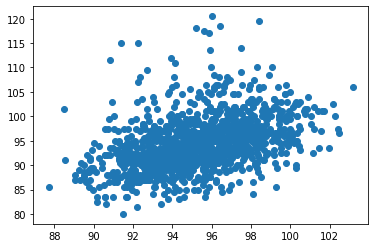

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime

# TODO
# adjust how atk and def ratings are calculated
# right now, they weight each game equally
# which overweights the possessions in high possession games

# NOTE
# gamma regressor may not be optimal for this projection
# use this to experiment with Keras/TensorFlow

game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/NBA/Possession Data/CSV Files/2007-2022.csv').drop('Unnamed: 0', axis=1).dropna().reset_index(drop=True)
game_data['Pace'] = np.divide(np.add(game_data['Home Possessions'], game_data['Away Possessions']), 2)

# Build sample/test datasets to perform repeated tests
# For example, sample goes through 2016 season, test 2017 season
# then reset sample to go through 2017, and test 2018 season
# That is the best way to leverage the massive quantity of data available

sample_data = game_data[game_data['Season'] < 2015]
test_data = game_data[game_data['Season'] == 2015].reset_index(drop=True)

# Create sample datasets to train model

sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]
sample_pace = [[sample_data['Home Pace'][x], sample_data['Away Pace'][x]] for x in range(len(sample_data))]

# Initialize a gamma linear distribution model

gld_home = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_away = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_pace = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)

# Fit the model based on the sample data

gld_home.fit(sample_home, np.array(sample_data['Home Eff']))
gld_away.fit(sample_away, np.array(sample_data['Away Eff']))
gld_pace.fit(sample_pace, np.array(sample_data['Pace']))

# Create test datasets

pred_home = [[test_data['Home Atk'][x], test_data['Away Def'][x]] for x in range(len(test_data))]
pred_away = [[test_data['Away Atk'][x], test_data['Home Def'][x]] for x in range(len(test_data))]
pred_pace = [[test_data['Home Pace'][x], test_data['Away Pace'][x]] for x in range(len(test_data))]

# Use the model to predict outcomes in the test data

model_home_eff = gld_home.predict(pred_home)
model_away_eff = gld_away.predict(pred_away)
model_pace = gld_pace.predict(pred_pace)

test_data['Proj Pace'] = np.array(model_pace)
test_data['Proj Home Eff'] = np.array(model_home_eff)
test_data['Proj Home Points'] = np.multiply(test_data['Proj Home Eff'], test_data['Proj Pace'])
test_data['Proj Away Eff'] = np.array(model_away_eff)
test_data['Proj Away Points'] = np.multiply(test_data['Proj Away Eff'], test_data['Proj Pace'])

print(test_data['Home Points'].corr(test_data['Proj Home Points']))
print(test_data['Away Points'].corr(test_data['Proj Away Points']))
print(test_data['Proj Pace'].corr(test_data['Pace']))

plt.scatter(test_data['Proj Pace'], test_data['Pace'])
plt.show()